In [ ]:
# load MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [ ]:
# create X and y variables from data and target vectors
X, y = mnist['data'], mnist['target']

In [ ]:
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]

In [ ]:
# reshape the row 0 vector into a 28 by 28 matrix
some_digit_image = some_digit.reshape(28, 28)

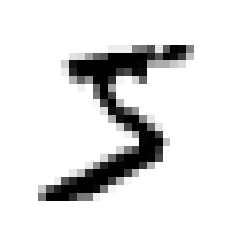

In [ ]:
# display the 28 by 28 matrix as an image in binary (black/white)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# looks like a five, check target at 0
y[0]

'5'

In [ ]:
# target is a string, will need to cast to a integer (unsigned 8 bit)
import numpy as np

y = y.astype(np.uint8)

In [ ]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [ ]:
# MNIST data set is already split into training (60,000 images) and test (last 10,000 images)
# these sets are already pre-shuffled
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# modify data to turn this into a binary classifier
# 5 or not 5, two cases (5 = true, not 5 = false)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
# use SGDClassifier as it handles large data well and uses instances one at a time
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# use the prior some_digit which is a 5 to quickly test
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
# creation of customized cross validation using Stratified Sampling
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=False, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [ ]:
# default cross_val_score 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# looks good but 10% of images are 5s, so guessing never 5 results in a 90% accuracy
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
# check the model that guesses never 5
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [ ]:
# model is right 90% of the time as we imagine
# shows why "accuracy" is not a good metric when some targets occur more frequently than others
# confusion matrix is much better
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# rows are actuals, columns are predicteds
# row 1 - actual non 5
# row 2 - actual 5
# column 1 - predicted non 5
# column 2 - predicted 5
# 53892 - True Negative (correctly classified as non-5)
# 3530 - True Positive (correctly classified as 5)
# 687 - False Positive (wrongly classified as 5)
# 1891 - False Negative (wrongly classified as non-5)

# perfect classifier has in its off diagonals
y_train_perfect_predicts = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predicts)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
# precision = accuracy of positive predictions (TP / (TP + FP))
# precision by itself is not enough though as only making 1 prediction would = 100%
# offset used is "RECALL" --> aka True Positive Rate or ratio of positives correctly detected
# (TP / (TP + FN))

In [ ]:
# when predicting a 5, it is right 83% of the time
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
# out of all 5s, it detects 65% of them
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [ ]:
# F1 combines the two using a harmonic mean
# harmonic mean gives more weight to lower values
# classifier gets a high F1 ONLY if both recall and precision are high
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
# F1 rewards classifiers with similar precision and recall
# not always the best to use
# i.e. when detecting safe videos for kids you would want high precision
# and low recall (rejects many good videos but is accurate on the ones it classifies)

# to detect shoplifters you would want the opposite, detects all instances
# of shoplifting even if the ones it detects are misclassified

# can't have both (precision/recall tradeoff)

In [ ]:
# SGD Classifiers use a decision function with a threshold of 0 to make the
# final classification decision
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
# correctly predicts a 5
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
# incorrectly predicts non-5, decreases recall but would eventually increase precision
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [ ]:
# build precision recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

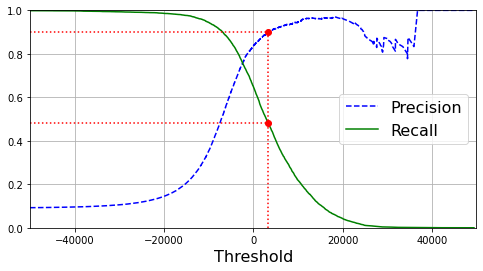

In [ ]:
# plot recall curve
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend(loc="center right", fontsize=16) 
  plt.xlabel("Threshold", fontsize=16)     
  plt.grid(True)                          
  plt.axis([-50000, 50000, 0, 1])          

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")


In [ ]:
recall_90_precision

0.4799852425751706

In [ ]:
threshold_90_precision

3370.0194991439557

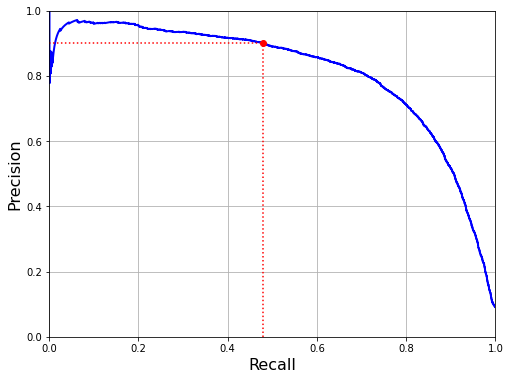

In [ ]:
# can also plot precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [ ]:
# 90% precision available at 3370 threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

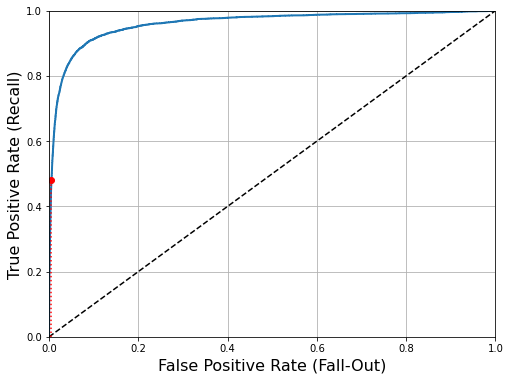

In [ ]:
# ROC = receiver operating characteristic
# similar to precision/recall curve but plots recall (true positive rate) vs. false positive rate
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:") 
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

In [ ]:
# higher recall equals more false positives
# dotted line is a purely random classifier
# better the higher the curve is up and to the left

# measuring area under the curve is a good way to compare classifiers
# perfect is ROC AUC equal to 1

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
# USE PR curve whenever the positive class is rare OR when you care more about false
# positives than false negatives
# OTHERWISE USE ROC CURVE

In [ ]:
# Train RandomForestClassifier and compare 
# no decision_function() for RF, use predict_proba()

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

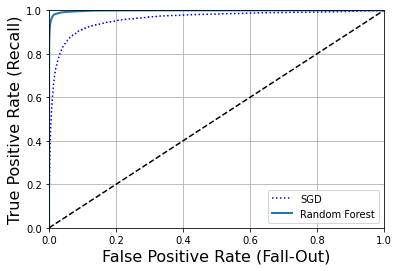

In [ ]:
# RF is better than the SGD classifier
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_s = (y_scores_forest > 0.5)

In [ ]:
precision_score(y_train_5, y_s)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_s)

0.8662608374838591

Multiclass Classification

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
# SciKitLearn trained 10 seperate models (one for each digit) and then selected
# the one scoring the highest in the decision function (i.e. 5 here)
# OneVsOne method (instead of OneVsRest)
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# target classes are in .classes_ and are ordered by value which in this 
# case syncs with the actual class (will not always be the case)
svm_clf.classes_[5]

5

In [ ]:
# able to force use of OneVsRest
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
ovr_clf.estimators_

In [ ]:
# training SGD straight up works as it can classify into multiple classes out of box
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# can improve if we use scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)